# MMIK lab 10

In [19]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

## algorytm Grovera (wersja IBM)

In [20]:
n = 2
grover_circuit = QuantumCircuit(n)

In [21]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [22]:
grover_circuit = initialize_s(grover_circuit, [0,1])

# Oracle
grover_circuit.cz(0,1) 

# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

## Zastosowanie Measurement Error Mitigation

In [23]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [24]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [25]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q15_0: ─░─┤M├───
        ░ └╥┘┌─┐
q15_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c1: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q15_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q15_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q15_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q15_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q15_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q15_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 



In [26]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2022-06-20 23:04:50,214: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibm_nairobi


In [27]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, device)
qobj = assemble(t_qc, shots=10000)
cal_results = device.run(qobj, shots=10000).result()

/tmp/ipykernel_1489938/2826048687.py:4: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  cal_results = device.run(qobj, shots=10000).result()


In [28]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [35]:
grover_circuit.measure_all()
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [36]:
results = job.result()
noisy_counts = results.get_counts(grover_circuit)
print(noisy_counts)

{'00': 15, '01': 212, '10': 208, '11': 3565}


In [37]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

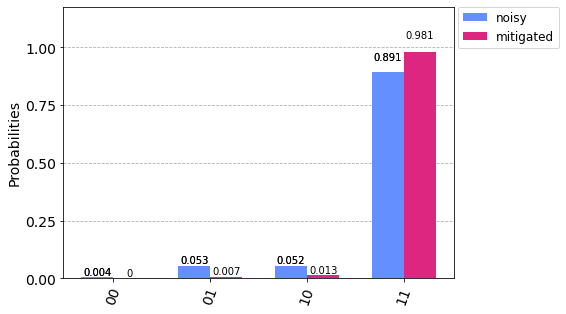

In [38]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])